# Fake News Detection

## Inspiration
With every news channel constantly wanting to attract more and more consumers on their page, it becomes increasingly hard to determine which news articles are real and which are seeking clicks through false headlines and false information. I personally do not want to be misled into believing something that is not true so I wanted to create an app that would tell me whether certain news is true or not.

We see the consequences of fake news in our culture everyday. A good example would be fake news about celebrities that could ruin their image.

In [1]:
# import necessary libraries to work with data and nlp models

import tensorflow as tf
# import torch
from transformers import pipeline
from datasets import Dataset, DatasetDict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# read in the data
all_data_news = pd.read_csv('WELFake_Dataset.csv', index_col=0)
# label: 0 = fake, 1 = real
all_data_news.head(2)

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1


## Plan
We will be using Hugging Face, an AI company, that offers pretrained models (which includes NLP models), to detect fake news.

**Why not train our own model?** An NLP model requires extensive data which often takes days to train, and takes up a lot of space. It is also unethical to train your own data when there are pretrained models which already exist.

#### Split Data

In [3]:
# X = all_data_news[['title', 'text', 'label']]
# y = all_data_news[['label']]

# 70% train, 20% test, 10% validation split
X_train_val, X_test = train_test_split(all_data_news, test_size=0.2, random_state=1)
X_train, X_val = train_test_split(X_train_val, test_size=0.125, random_state=1)

We'll first use the fake news model given to us from Hugging Face. Then we'll fine tune our own fake news model.

In [4]:
model = 'jy46604790/Fake-News-Bert-Detect'
classifier = pipeline('sentiment-analysis', model=model)

In [5]:
news_titles = X_test['title']
news_text = X_test['text']
print('Number of NaN titles:', news_titles.isna().sum())
print('Number of NaN texts:', news_text.isna().sum())
print('Rows w/ NaN title or NaN text:', X_test.isna().any(axis=1).sum())
print('Rows w/ NaN title and NaN text:', (X_test.isna().sum(axis=1) > 1).sum())

Number of NaN titles: 105
Number of NaN texts: 7
Rows w/ NaN title or NaN text: 112
Rows w/ NaN title and NaN text: 0


We see from above that for every row that has a NaN title, it was a text value that is NOT NaN, so therefore we can replace all NaN title's with their corresponding text value to check for fake news.

In [6]:
X_test['title'].fillna(X_test['text'], inplace=True)
filled_news_titles = X_test['title']
print('New Number of NaN titles:', filled_news_titles.isna().sum())

New Number of NaN titles: 0


In [7]:
# this is how i was able to move the predictions from the Hugging Face model to a csv file

# filled_news_titles = list(filled_news_titles)
# tokenizer_kwargs = {'truncation':True,'max_length':512}
# class_dict = classifier(filled_news_titles,**tokenizer_kwargs)
# scores = pd.DataFrame({'real':class_dict})
# scores.to_csv('scores.csv')


In [8]:
scores = pd.read_csv('scores.csv', index_col=0)
scores.head(2)

,real
0,"{'label': 'LABEL_0', 'score': 0.9990565180778503}"
1,"{'label': 'LABEL_0', 'score': 0.9979349374771118}"


In [9]:
scores.loc[scores['real'].str.contains('LABEL_0'), 'real'] = '0'
scores.loc[scores['real'].str.contains('LABEL_1'), 'real'] = '1'
scores.head(2)

,real
0,0
1,0


In [10]:
from sklearn.metrics import accuracy_score

scores['real'] = pd.to_numeric(scores['real'])
pred = scores['real']
real = X_test['label']
print('\'jy46604790/Fake-News-Bert-Detect\' Accuracy Score:', accuracy_score(real, pred))

'jy46604790/Fake-News-Bert-Detect' Accuracy Score: 0.24911624038261593


Wow! That accuracy score is horrendous. Let's now finetune our own model to the Fake News Detection problem from a pretrained model.

In [11]:
# could also use 'BertTokenizer' but it's suggested to use Auto for adaptability
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

# this is the general bert model, most used bert model on Hugging Face
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prepare the input so that we concatenate the title and text of the news.

In [12]:
X_test = X_test.fillna('')
X_test['full'] = X_test['title'].astype(str) + ' ' + X_test['text'].astype(str)
X_test = X_test.drop(['title', 'text'], axis=1)
X_test.head(2)

,label,full
64441,1,Trump Exposed As A Speed Tweaker: Suddenly Hi...
2317,0,Shared Mission to Pardon U.S. Soldiers Who Kil...


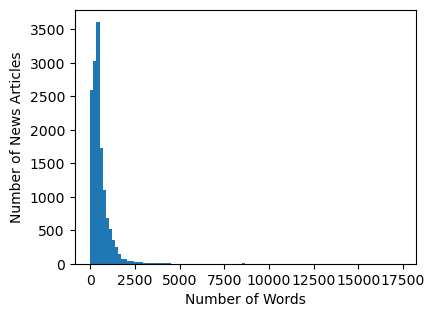

95th Percentile of Number of Words: 1424.70


In [13]:
word_len = [len(x.split()) for x in X_test['full']]
plt.figure(figsize=(4.4, 3.3))
plt.hist(word_len, bins=100)
plt.xlabel('Number of Words')
plt.ylabel('Number of News Articles')
plt.show()
word_np = np.asarray(word_len)
print('95th Percentile of Number of Words:', '%.2f' % np.percentile(word_np, 95))

We see that most news articles don't go over 1500 words, but since BERT caps the number of tokens at 512 anyways, we'll just truncate at 512 tokens for each news article.

In [14]:
X_train = X_train.fillna('')
X_train['full'] = X_train['title'].astype(str) + ' ' + X_train['text'].astype(str)
X_train = X_train.drop(['title', 'text'], axis=1)
X_train.head(2)

,label,full
47094,1,DETROIT FREE PRESS EDITOR Calls For Gruesome M...
53301,1,‘Shoot Hillary In The F*ckin Head’: Conservat...


In [15]:
X_val = X_val.fillna('')
X_val['full'] = X_val['title'].astype(str) + ' ' + X_val['text'].astype(str)
X_val = X_val.drop(['title', 'text'], axis=1)
X_val.head(2)

,label,full
71158,0,Trump predicts 'very massive recession' in U.S...
46946,1,RIGGED! DOJ Weiner Email Probe Will Be Led By ...


In [16]:
X_train_test_ds = DatasetDict({
    "train": Dataset.from_pandas(X_train),
    "validation": Dataset.from_pandas(X_val),
    "test": Dataset.from_pandas(X_test)
})

In [17]:
X_train_test_ds

DatasetDict({
    train: Dataset({
        features: ['label', 'full', '__index_level_0__'],
        num_rows: 50493
    })
    validation: Dataset({
        features: ['label', 'full', '__index_level_0__'],
        num_rows: 7214
    })
    test: Dataset({
        features: ['label', 'full', '__index_level_0__'],
        num_rows: 14427
    })
})

In [18]:
def tokenize_function(dataset_d):
    return tokenizer(dataset_d['full'], truncation=True)

In [19]:
tokenized_datasets = X_train_test_ds.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/50493 [00:00<?, ? examples/s]

Map:   0%|          | 0/7214 [00:00<?, ? examples/s]

Map:   0%|          | 0/14427 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'full', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50493
    })
    validation: Dataset({
        features: ['label', 'full', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7214
    })
    test: Dataset({
        features: ['label', 'full', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 14427
    })
})

In [20]:
samples = tokenized_datasets["train"][:8]
samples = {k: v for k, v in samples.items() if k not in ["__index_level_0__", "full"]}
[len(x) for x in samples["input_ids"]]

[512, 481, 512, 512, 374, 302, 512, 307]

In [21]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='tf')
tf_train_dataset = tokenized_datasets['train'].to_tf_dataset(
    columns=['attention_mask', 'input_ids', 'token_type_ids'],
    label_cols=['label'],
    shuffle=True,
    collate_fn = data_collator,
    batch_size=8
)
tf_valid_dataset = tokenized_datasets['train'].to_tf_dataset(
    columns=['attention_mask', 'input_ids', 'token_type_ids'],
    label_cols=['label'],
    shuffle=False,
    collate_fn = data_collator,
    batch_size=8
)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [22]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
from tensorflow.keras.optimizers import Adam

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = Adam()
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [24]:
model.fit(tf_train_dataset, validation_data=tf_valid_dataset, epochs=2)

Epoch 1/2


2023-12-13 17:12:18.921128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [50493]
	 [[{{node Placeholder/_0}}]]
2023-12-13 17:12:18.921391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [50493]
	 [[{{node Placeholder/_0}}]]
2023-12-13 17:12:18.973659: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 174/6312 [..............................] - ETA: 41:13:38 - loss: 0.7668 - accuracy: 0.4964